# Decentralized Data Distribution Network Setup

In [1]:
from ipaddress import ip_address, IPv4Address, IPv6Address, IPv4Network, IPv6Network
import ipaddress

from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager

fablib = fablib_manager()

fablib.show_config();

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Token File,/home/fabric/.tokens.json
Bastion Host,bastion.fabric-testbed.net
Bastion Username,tyler_t_williams_0000221832
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Log File,/tmp/fablib/fablib.log
Log Level,INFO


In [2]:
fablib.list_sites();

Name,State,Address,Location,PTP Capable,Hosts,CPUs,Cores Available,Cores Capacity,Cores Allocated,Ram Available,Ram Capacity,Ram Allocated,Disk Available,Disk Capacity,Disk Allocated,Basic NIC Available,Basic NIC Capacity,Basic NIC Allocated,P4-Switch Available,P4-Switch Capacity,P4-Switch Allocated,ConnectX-6 Available,ConnectX-6 Capacity,ConnectX-6 Allocated,ConnectX-5 Available,ConnectX-5 Capacity,ConnectX-5 Allocated,NVMe Available,NVMe Capacity,NVMe Allocated,Tesla T4 Available,Tesla T4 Capacity,Tesla T4 Allocated,RTX6000 Available,RTX6000 Capacity,RTX6000 Allocated,A30 Available,A30 Capacity,A30 Allocated,A40 Available,A40 Capacity,A40 Allocated,U280 Available,U280 Capacity,U280 Allocated
AMST,Active,"Science Park 904, 1098 XH Amsterdam","(52.3544941, 4.9557553)",True,3,6,132,384,252,634,1434,800,58818,64068,5250,313,381,68,0,0,0,2,3,1,2,2,0,10,10,0,0,0,0,0,0,0,4,4,0,0,0,0,0,0,0
STAR,Active,"710 North Lakeshore Drive, 60611","(42.2359989, -88.1575427)",True,6,12,404,768,364,1676,2820,1144,102576,109696,7120,675,762,87,1,1,0,1,2,1,6,6,0,18,20,2,2,6,4,0,6,6,0,0,0,0,0,0,1,1,0
RUTG,Active,"120 Avenue E,Piscataway, New Jersey","(40.5224962, -74.4405719)",True,5,10,436,640,204,1582,2390,808,102143,107463,5320,540,635,95,0,0,0,2,2,0,4,4,0,16,16,0,0,0,0,0,0,0,8,8,0,0,0,0,1,1,0
TACC,Active,"10100 Burnet Rd,Austin, TX 78758","(30.3899405, -97.7261807)",False,5,10,140,640,500,774,2390,1616,98243,107463,9220,573,635,62,0,0,0,2,2,0,4,4,0,16,16,0,0,4,4,4,6,2,0,0,0,0,0,0,1,1,0
NCSA,Active,"1725 S Oak St.,Champaign, IL 61820","(40.09584, -88.2415369)",True,3,6,302,384,82,1106,1434,328,60151,64161,4010,340,381,41,0,0,0,2,2,0,2,2,0,10,10,0,2,2,0,3,3,0,0,0,0,0,0,0,1,1,0
DALL,Active,"1950 N Stemmons Fwy,Dallas TX 75207","(32.7990816, -96.8206903)",True,3,6,156,384,228,698,1434,736,58721,64161,5440,341,381,40,0,0,0,2,2,0,2,2,0,10,10,0,2,2,0,3,3,0,0,0,0,0,0,0,1,1,0
MAX,Active,"4161 Fieldhouse Drive,College Park,MD 20742","(38.9886345, -76.9434794)",True,5,10,502,640,138,1934,2390,456,102753,107463,4710,591,635,44,0,0,0,2,2,0,4,4,0,16,16,0,4,4,0,3,6,3,0,0,0,0,0,0,1,1,0
SALT,Active,"572 Delong Street,Salt Lake City, UT 84104","(40.7570751, -111.9534664)",False,3,6,210,384,174,878,1434,556,58791,64161,5370,319,381,62,0,0,0,2,2,0,2,2,0,10,10,0,2,2,0,2,3,1,0,0,0,0,0,0,1,1,0
UCSD,Active,"10100 Hopkins Drive,CA 92093","(32.8886802, -117.239324)",True,5,10,288,640,352,1286,2390,1104,46887,58717,11830,583,635,52,1,1,0,2,2,0,4,4,0,14,16,2,4,4,0,1,6,5,0,0,0,0,0,0,1,1,0
MICH,Active,"2530 Draper Dr,Ann Arbor, MI 48109","(42.2931086, -83.7101319)",True,3,6,244,384,140,978,1434,456,59641,64161,4520,333,381,48,1,1,0,1,2,1,2,2,0,10,10,0,2,2,0,2,3,1,0,0,0,0,0,0,1,1,0


In [3]:
# Optional list of fields to display.
# fields=None desplays all fields.
fields=['name','cores_available','ram_available','disk_available','nic_basic_available']

In [4]:
output_table = fablib.list_sites(fields=fields)

Name,Cores Available,Ram Available,Disk Available,Basic NIC Available
AMST,132,634,58818,313
STAR,404,1676,102576,675
RUTG,436,1582,102143,540
TACC,140,774,98243,573
NCSA,302,1106,60151,340
DALL,156,698,58721,341
MAX,502,1934,102753,591
SALT,210,878,58791,319
UCSD,288,1286,46887,583
MICH,244,978,59641,333


In [2]:
slice_name="project-" + fablib.get_bastion_username()

In [3]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


In [7]:
while True:
    ne_site_name = "RUTG"
    if ( (fablib.resources.get_core_available(ne_site_name) > 8) and
        (fablib.resources.get_component_available(ne_site_name, 'SharedNIC-ConnectX-6') > 8) ):
        fablib.show_site(ne_site_name)
        break
    else:
        print(f"Not enough resources available at: {ne_site_name}")
        break

while True:
    se_site_name = "GATECH"
    if ( (fablib.resources.get_core_available(se_site_name) > 8) and
        (fablib.resources.get_component_available(se_site_name, 'SharedNIC-ConnectX-6') > 8) ):
        fablib.show_site(se_site_name)
        break
    else:
        print(f"Not enough resources available at: {se_site_name}")
        break
        
while True:
    sw_site_name = "UTAH"
    if ( (fablib.resources.get_core_available(sw_site_name) > 8) and
        (fablib.resources.get_component_available(sw_site_name, 'SharedNIC-ConnectX-6') > 8) ):
        fablib.show_site(sw_site_name)
        break
    else:
        print(f"Not enough resources available at: {sw_site_name}")
        break

while True:
    sink_site_name = "DALL"
    if ( (fablib.resources.get_core_available(sink_site_name) > 8) and
        (fablib.resources.get_component_available(sink_site_name, 'SharedNIC-ConnectX-6') > 8) ):
        fablib.show_site(sink_site_name)
        break
    else:
        print(f"Not enough resources available at: {sink_site_name}")
        break


Name,RUTG
State,Active
Address,"120 Avenue E,Piscataway, New Jersey"
Location,"(40.5224962, -74.4405719)"
PTP Capable,True
Hosts,5
CPUs,10
Cores Available,436
Cores Capacity,640
Cores Allocated,204
Ram Available,1582


Name,GATECH
State,Active
Address,"760 West Peachtree Street NW,Atlanta, GA 30308"
Location,"(33.7753991, -84.3875488)"
PTP Capable,True
Hosts,5
CPUs,10
Cores Available,346
Cores Capacity,640
Cores Allocated,294
Ram Available,1590


Name,UTAH
State,Active
Address,"875 South West Temple,Salt Lake City, UT 84101"
Location,"(40.7503666, -111.893838)"
PTP Capable,True
Hosts,5
CPUs,10
Cores Available,348
Cores Capacity,640
Cores Allocated,292
Ram Available,1206


Name,DALL
State,Active
Address,"1950 N Stemmons Fwy,Dallas TX 75207"
Location,"(32.7990816, -96.8206903)"
PTP Capable,True
Hosts,3
CPUs,6
Cores Available,156
Cores Capacity,384
Cores Allocated,228
Ram Available,698


In [8]:
# this cell sets up sink nodes
sink_rtr = slice.add_node(name='sink_router', site=sink_site_name, cores=2, ram=4, disk=10, image='default_ubuntu_20')
sink_rtr.add_fabnet()


sink_node = slice.add_node(name='sink', site=sink_site_name, cores=2, ram=4, disk=10, image='default_ubuntu_20')
sink_node.add_fabnet()


In [9]:
# this cell sets up the NE nodes
NE_1 = slice.add_node(name='NE_1', site=ne_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
NE_2 = slice.add_node(name='NE_2', site=ne_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
NE_3 = slice.add_node(name='NE_3', site=ne_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
NE_4 = slice.add_node(name='NE_4', site=ne_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')

NE_1.add_fabnet()
NE_2.add_fabnet()
NE_3.add_fabnet()
NE_4.add_fabnet()

In [10]:
# this cell sets up the SE nodes
SE_1 = slice.add_node(name='SE_1', site=se_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
SE_2 = slice.add_node(name='SE_2', site=se_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
SE_3 = slice.add_node(name='SE_3', site=se_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
SE_4 = slice.add_node(name='SE_4', site=se_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')

SE_1.add_fabnet()
SE_2.add_fabnet()
SE_3.add_fabnet()
SE_4.add_fabnet()

In [11]:
# this cell sets up the SW nodes
SW_1 = slice.add_node(name='SW_1', site=sw_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
SW_2 = slice.add_node(name='SW_2', site=sw_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
SW_3 = slice.add_node(name='SW_3', site=sw_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')
SW_4 = slice.add_node(name='SW_4', site=sw_site_name, cores=1, ram=2, disk=5, image='default_ubuntu_20')

SW_1.add_fabnet()
SW_2.add_fabnet()
SW_3.add_fabnet()
SW_4.add_fabnet()

In [12]:
slice.submit()


Retry: 11, Time: 414 sec


ID,6da90170-6e3c-42b7-bbdb-5ec725c3ca0d
Name,project-tyler_t_williams_0000221832
Lease Expiration (UTC),2024-12-07 23:19:43 +0000
Lease Start (UTC),2024-12-06 23:19:43 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
9e43c044-2960-4a07-82bf-dbb7bcafc2a7,NE_1,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe6a:ff98,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe6a:ff98,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
37c8f919-4d5c-4b4f-b13c-9a1c367281b8,NE_2,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe38:d6ce,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe38:d6ce,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
3c0982bd-3b35-4704-8cb7-0151251ecf71,NE_3,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fee1:ade,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fee1:ade,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
f8090f05-7a70-49f9-bee1-4f1525b61f88,NE_4,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe51:d5a7,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe51:d5a7,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
444602d7-acbe-4c61-88eb-ee798493717b,SE_1,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe90:5413,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe90:5413,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
69bf12d8-1171-408e-bdc1-05f781685adc,SE_2,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe94:d3a4,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe94:d3a4,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
13c49ab5-f06e-454b-9850-b40f1fcc88ad,SE_3,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe88:2782,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe88:2782,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c86a55cc-0e0e-49e2-9d80-d0cb6975a9bc,SE_4,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe99:b110,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe99:b110,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
37d22cc9-d527-4f4f-8961-4bdbfae9e886,SW_1,1,2,10,default_ubuntu_20,qcow2,utah-w4.fabric-testbed.net,UTAH,ubuntu,2001:1948:417:7:f816:3eff:fe29:4aa0,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fe29:4aa0,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
50f2334a-40ec-419c-b9c7-dbe6fe58be68,SW_2,1,2,10,default_ubuntu_20,qcow2,utah-w4.fabric-testbed.net,UTAH,ubuntu,2001:1948:417:7:f816:3eff:fe93:d12f,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fe93:d12f,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
7e4a1222-6cb7-44b7-aa8e-b033e19b4242,FABNET_IPv4_DALL,L3,FABNetv4,DALL,10.133.137.0/24,10.133.137.1,Active,
b28bfd8a-3bdb-47ec-8cf5-a446b8654d6a,FABNET_IPv4_GATECH,L3,FABNetv4,GATECH,10.136.131.0/24,10.136.131.1,Active,
3c82abe4-6d85-4329-80af-3457a1321e60,FABNET_IPv4_RUTG,L3,FABNetv4,RUTG,10.141.1.0/24,10.141.1.1,Active,
e41976fa-fe8b-4f8a-878f-0e9700334435,FABNET_IPv4_UTAH,L3,FABNetv4,UTAH,10.132.4.0/24,10.132.4.1,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
sink_router-FABNET_IPv4_DALL_nic-p1,p1,sink_router,FABNET_IPv4_DALL,100,auto,,06:5C:8B:7E:54:F6,enp7s0,enp7s0,10.133.137.2,4,HundredGigE0/0/0/7
sink-FABNET_IPv4_DALL_nic-p1,p1,sink,FABNET_IPv4_DALL,100,auto,,0A:44:9D:CD:9A:85,enp7s0,enp7s0,10.133.137.3,4,HundredGigE0/0/0/7
NE_1-FABNET_IPv4_RUTG_nic-p1,p1,NE_1,FABNET_IPv4_RUTG,100,auto,,06:23:26:0D:F8:9D,enp7s0,enp7s0,10.141.1.4,4,HundredGigE0/0/0/9
NE_2-FABNET_IPv4_RUTG_nic-p1,p1,NE_2,FABNET_IPv4_RUTG,100,auto,,06:39:0A:92:D8:ED,enp7s0,enp7s0,10.141.1.2,4,HundredGigE0/0/0/9
NE_3-FABNET_IPv4_RUTG_nic-p1,p1,NE_3,FABNET_IPv4_RUTG,100,auto,,06:DB:6B:54:F2:86,enp7s0,enp7s0,10.141.1.3,4,HundredGigE0/0/0/9
NE_4-FABNET_IPv4_RUTG_nic-p1,p1,NE_4,FABNET_IPv4_RUTG,100,auto,,06:E2:05:1B:58:66,enp7s0,enp7s0,10.141.1.5,4,HundredGigE0/0/0/9
SE_1-FABNET_IPv4_GATECH_nic-p1,p1,SE_1,FABNET_IPv4_GATECH,100,auto,,06:F0:0D:59:B2:D6,enp7s0,enp7s0,10.136.131.5,6,HundredGigE0/0/0/7
SE_2-FABNET_IPv4_GATECH_nic-p1,p1,SE_2,FABNET_IPv4_GATECH,100,auto,,0A:21:57:12:AA:6A,enp7s0,enp7s0,10.136.131.2,6,HundredGigE0/0/0/7
SE_3-FABNET_IPv4_GATECH_nic-p1,p1,SE_3,FABNET_IPv4_GATECH,100,auto,,12:25:CA:FB:25:CC,enp7s0,enp7s0,10.136.131.3,6,HundredGigE0/0/0/7
SE_4-FABNET_IPv4_GATECH_nic-p1,p1,SE_4,FABNET_IPv4_GATECH,100,auto,,12:99:CE:81:E5:B0,enp7s0,enp7s0,10.136.131.4,6,HundredGigE0/0/0/7



Time to print interfaces 445 seconds


'6da90170-6e3c-42b7-bbdb-5ec725c3ca0d'

In [13]:
slice.show();

ID,6da90170-6e3c-42b7-bbdb-5ec725c3ca0d
Name,project-tyler_t_williams_0000221832
Lease Expiration (UTC),2024-12-07 23:19:43 +0000
Lease Start (UTC),2024-12-06 23:19:43 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


In [14]:
slice.list_nodes();

ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
9e43c044-2960-4a07-82bf-dbb7bcafc2a7,NE_1,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe6a:ff98,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe6a:ff98,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
37c8f919-4d5c-4b4f-b13c-9a1c367281b8,NE_2,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe38:d6ce,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe38:d6ce,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
3c0982bd-3b35-4704-8cb7-0151251ecf71,NE_3,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fee1:ade,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fee1:ade,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
f8090f05-7a70-49f9-bee1-4f1525b61f88,NE_4,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe51:d5a7,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe51:d5a7,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
444602d7-acbe-4c61-88eb-ee798493717b,SE_1,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe90:5413,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe90:5413,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
69bf12d8-1171-408e-bdc1-05f781685adc,SE_2,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe94:d3a4,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe94:d3a4,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
13c49ab5-f06e-454b-9850-b40f1fcc88ad,SE_3,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe88:2782,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe88:2782,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c86a55cc-0e0e-49e2-9d80-d0cb6975a9bc,SE_4,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe99:b110,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe99:b110,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
37d22cc9-d527-4f4f-8961-4bdbfae9e886,SW_1,1,2,10,default_ubuntu_20,qcow2,utah-w4.fabric-testbed.net,UTAH,ubuntu,2001:1948:417:7:f816:3eff:fe29:4aa0,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fe29:4aa0,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
50f2334a-40ec-419c-b9c7-dbe6fe58be68,SW_2,1,2,10,default_ubuntu_20,qcow2,utah-w4.fabric-testbed.net,UTAH,ubuntu,2001:1948:417:7:f816:3eff:fe93:d12f,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fe93:d12f,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


In [5]:
from datetime import datetime
from datetime import timezone
from datetime import timedelta

# Set end date to 7 days from now
end_date = (datetime.now(timezone.utc) + timedelta(days=7)).strftime("%Y-%m-%d %H:%M:%S %z")
slice.renew(end_date)


Retry: 1, Time: 136 sec


ID,6da90170-6e3c-42b7-bbdb-5ec725c3ca0d
Name,project-tyler_t_williams_0000221832
Lease Expiration (UTC),2024-12-17 08:41:59 +0000
Lease Start (UTC),2024-12-06 23:19:43 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


ID,Name,Cores,RAM,Disk,Image,Image Type,Host,Site,Username,Management IP,State,Error,SSH Command,Public SSH Key File,Private SSH Key File
9e43c044-2960-4a07-82bf-dbb7bcafc2a7,NE_1,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe6a:ff98,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe6a:ff98,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
37c8f919-4d5c-4b4f-b13c-9a1c367281b8,NE_2,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe38:d6ce,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe38:d6ce,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
3c0982bd-3b35-4704-8cb7-0151251ecf71,NE_3,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fee1:ade,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fee1:ade,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
f8090f05-7a70-49f9-bee1-4f1525b61f88,NE_4,1,2,10,default_ubuntu_20,qcow2,rutg-w3.fabric-testbed.net,RUTG,ubuntu,2620:0:d61:4101:f816:3eff:fe51:d5a7,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe51:d5a7,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
444602d7-acbe-4c61-88eb-ee798493717b,SE_1,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe90:5413,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe90:5413,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
69bf12d8-1171-408e-bdc1-05f781685adc,SE_2,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe94:d3a4,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe94:d3a4,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
13c49ab5-f06e-454b-9850-b40f1fcc88ad,SE_3,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe88:2782,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe88:2782,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
c86a55cc-0e0e-49e2-9d80-d0cb6975a9bc,SE_4,1,2,10,default_ubuntu_20,qcow2,gatech-w2.fabric-testbed.net,GATECH,ubuntu,2610:148:1f00:9f01:f816:3eff:fe99:b110,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe99:b110,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
37d22cc9-d527-4f4f-8961-4bdbfae9e886,SW_1,1,2,10,default_ubuntu_20,qcow2,utah-w4.fabric-testbed.net,UTAH,ubuntu,2001:1948:417:7:f816:3eff:fe29:4aa0,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fe29:4aa0,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key
50f2334a-40ec-419c-b9c7-dbe6fe58be68,SW_2,1,2,10,default_ubuntu_20,qcow2,utah-w4.fabric-testbed.net,UTAH,ubuntu,2001:1948:417:7:f816:3eff:fe93:d12f,Active,,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:1948:417:7:f816:3eff:fe93:d12f,/home/fabric/work/fabric_config/slice_key.pub,/home/fabric/work/fabric_config/slice_key


ID,Name,Layer,Type,Site,Subnet,Gateway,State,Error
7e4a1222-6cb7-44b7-aa8e-b033e19b4242,FABNET_IPv4_DALL,L3,FABNetv4,DALL,10.133.137.0/24,10.133.137.1,Active,
b28bfd8a-3bdb-47ec-8cf5-a446b8654d6a,FABNET_IPv4_GATECH,L3,FABNetv4,GATECH,10.136.131.0/24,10.136.131.1,Active,
3c82abe4-6d85-4329-80af-3457a1321e60,FABNET_IPv4_RUTG,L3,FABNetv4,RUTG,10.141.1.0/24,10.141.1.1,Active,
e41976fa-fe8b-4f8a-878f-0e9700334435,FABNET_IPv4_UTAH,L3,FABNetv4,UTAH,10.132.4.0/24,10.132.4.1,Active,


Name,Short Name,Node,Network,Bandwidth,Mode,VLAN,MAC,Physical Device,Device,IP Address,Numa Node,Switch Port
sink_router-FABNET_IPv4_DALL_nic-p1,p1,sink_router,FABNET_IPv4_DALL,100,auto,,06:5C:8B:7E:54:F6,enp7s0,enp7s0,10.133.137.2,4,HundredGigE0/0/0/7
sink-FABNET_IPv4_DALL_nic-p1,p1,sink,FABNET_IPv4_DALL,100,auto,,0A:44:9D:CD:9A:85,enp7s0,enp7s0,10.133.137.3,4,HundredGigE0/0/0/7
NE_1-FABNET_IPv4_RUTG_nic-p1,p1,NE_1,FABNET_IPv4_RUTG,100,auto,,06:23:26:0D:F8:9D,enp7s0,enp7s0,10.141.1.4,4,HundredGigE0/0/0/9
NE_2-FABNET_IPv4_RUTG_nic-p1,p1,NE_2,FABNET_IPv4_RUTG,100,auto,,06:39:0A:92:D8:ED,enp7s0,enp7s0,10.141.1.2,4,HundredGigE0/0/0/9
NE_3-FABNET_IPv4_RUTG_nic-p1,p1,NE_3,FABNET_IPv4_RUTG,100,auto,,06:DB:6B:54:F2:86,enp7s0,enp7s0,10.141.1.3,4,HundredGigE0/0/0/9
NE_4-FABNET_IPv4_RUTG_nic-p1,p1,NE_4,FABNET_IPv4_RUTG,100,auto,,06:E2:05:1B:58:66,enp7s0,enp7s0,10.141.1.5,4,HundredGigE0/0/0/9
SE_1-FABNET_IPv4_GATECH_nic-p1,p1,SE_1,FABNET_IPv4_GATECH,100,auto,,06:F0:0D:59:B2:D6,enp7s0,enp7s0,10.136.131.5,6,HundredGigE0/0/0/7
SE_2-FABNET_IPv4_GATECH_nic-p1,p1,SE_2,FABNET_IPv4_GATECH,100,auto,,0A:21:57:12:AA:6A,enp7s0,enp7s0,10.136.131.2,6,HundredGigE0/0/0/7
SE_3-FABNET_IPv4_GATECH_nic-p1,p1,SE_3,FABNET_IPv4_GATECH,100,auto,,12:25:CA:FB:25:CC,enp7s0,enp7s0,10.136.131.3,6,HundredGigE0/0/0/7
SE_4-FABNET_IPv4_GATECH_nic-p1,p1,SE_4,FABNET_IPv4_GATECH,100,auto,,12:99:CE:81:E5:B0,enp7s0,enp7s0,10.136.131.4,6,HundredGigE0/0/0/7



Time to print interfaces 157 seconds


In [16]:
# install packages
# this will take a while and will run in background while you do other steps
packages = ['net-tools', 'iperf3', 'moreutils']

for n in slice.get_nodes():
    pkg = " ".join(packages)
    n.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)


In [17]:
l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

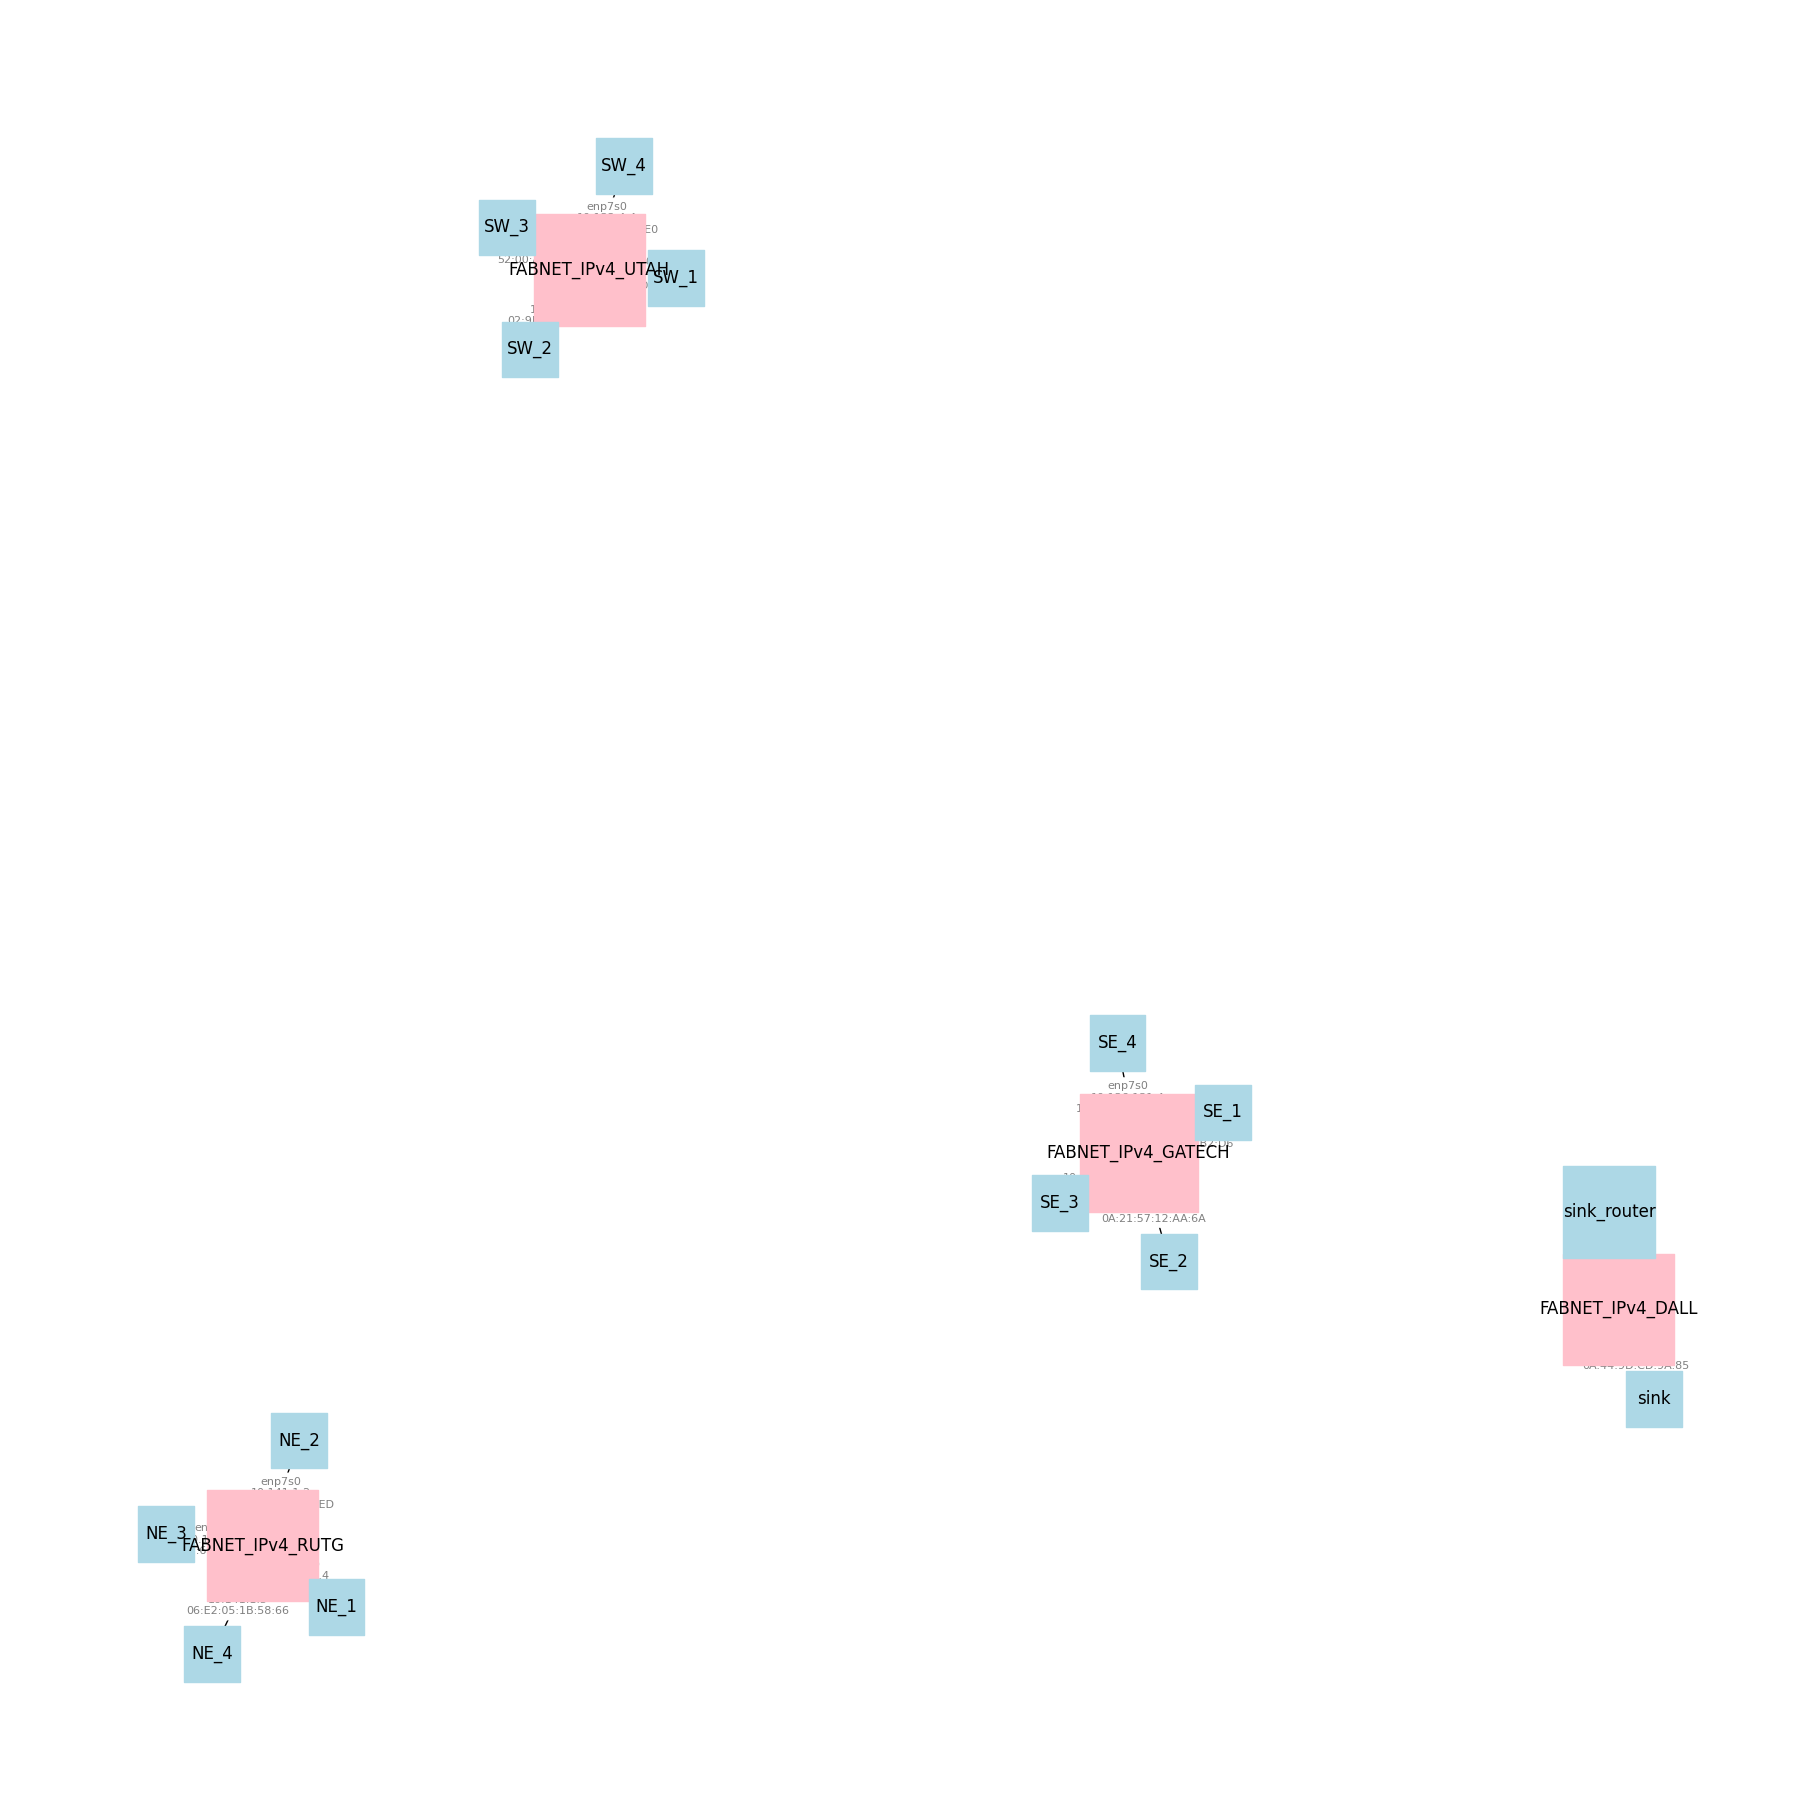

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

In [19]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
sink_router,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe02:3868
sink,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3000:f816:3eff:fe05:546b
NE_1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe6a:ff98
NE_2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe38:d6ce
NE_3,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fee1:ade
NE_4,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2620:0:d61:4101:f816:3eff:fe51:d5a7
SE_1,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe90:5413
SE_2,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe94:d3a4
SE_3,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2610:148:1f00:9f01:f816:3eff:fe88:2782


In [20]:
slice.update()
_ = slice.show()

ID,6da90170-6e3c-42b7-bbdb-5ec725c3ca0d
Name,project-tyler_t_williams_0000221832
Lease Expiration (UTC),2024-12-12 23:27:33 +0000
Lease Start (UTC),2024-12-06 23:19:43 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK


# When complete with the project

In [5]:
slice = fablib.get_slice(name=slice_name)
fablib.delete_slice(slice_name)

In [6]:
slice.update()
_ = slice.show()

ID,6da90170-6e3c-42b7-bbdb-5ec725c3ca0d
Name,project-tyler_t_williams_0000221832
Lease Expiration (UTC),2024-12-17 08:41:59 +0000
Lease Start (UTC),2024-12-06 23:19:43 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,StableOK
